# HySpecNet11k_Inference

> Inference

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

## Visualizing the Hyspecnec-11k dataset

In [ ]:
#|export

import os
import pandas as pd
from tqdm import tqdm

def scan_dataset(base_dir="/root/hsi-compression/datasets/hyspecnet-11k/patches"):
    """
    Scans the specified base directory for .tif and .npy files,
    and returns a DataFrame with details such as directory, filename,
    file extension, and file size in MB.

    Args:
        base_dir (str): The base directory to scan for files.

    Returns:
        pd.DataFrame: A DataFrame containing file details.
    """
    # List to hold file information
    file_data = []

    # Count the total number of files for progress tracking
    total_files = sum(len(files) for _, _, files in os.walk(base_dir))

    # Walk through the dataset directory with a progress bar
    print("Directory exists:", os.path.exists("/root/hsi-compression/datasets/hyspecnet-11k/patches"))
    with tqdm(total=total_files, desc="Scanning Files", unit="file") as pbar:
        for root, dirs, files in os.walk(base_dir):
            for file in files:
                if file.endswith(".tif") or file.endswith(".npy"):
                    file_path = os.path.join(root, file)
                    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
                    file_extension = os.path.splitext(file)[-1]
                    file_data.append([root, file, file_extension, file_size])
                pbar.update(1)

    # Create a DataFrame for better visualization
    df = pd.DataFrame(file_data, columns=["Directory", "Filename", "Extension", "Size (MB)"])
    return df


In [ ]:
# Call the function and display the DataFrame
dataset_overview = scan_dataset()
print("\nDataset Overview:")
print(dataset_overview.head())

Directory exists: True


Scanning Files: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 17182/17182 [00:00<00:00, 296967.27file/s]


Dataset Overview:
                                           Directory  \
0  /root/hsi-compression/datasets/hyspecnet-11k/p...   
1  /root/hsi-compression/datasets/hyspecnet-11k/p...   
2  /root/hsi-compression/datasets/hyspecnet-11k/p...   
3  /root/hsi-compression/datasets/hyspecnet-11k/p...   
4  /root/hsi-compression/datasets/hyspecnet-11k/p...   

                                            Filename Extension  Size (MB)  
0  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
1  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
2  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
3  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  
4  ENMAP01-____L2A-DT0000004950_20221103T162443Z_...      .npy  12.625122  


## Data Visualization

In [ ]:
#| export
import os
import random
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import Image, display

# Configure matplotlib for headless environments
import matplotlib
matplotlib.use('Agg')

# Define the base directory (update if needed)
BASE_DIR = "/root/hsi-compression/datasets/hyspecnet-11k/patches"

#|export
# Helper function to check if the image is mostly blank
def is_mostly_blank(image):
    """
    Checks if the image has less than 5% non-zero pixels.

    Args:
        image (np.ndarray): The image array.

    Returns:
        bool: True if the image is mostly blank, otherwise False.
    """
    non_zero_count = np.count_nonzero(image)
    total_count = image.size
    return (non_zero_count / total_count) < 0.05

#|export
# Helper function to enhance the image using contrast stretching
def enhance_image(image):
    """
    Enhances the image using contrast stretching.

    Args:
        image (np.ndarray): The image array.

    Returns:
        np.ndarray: The enhanced image array.
    """
    p2, p98 = np.nanpercentile(image, (2, 98))
    img_stretched = np.clip((image - p2) / (p98 - p2), 0, 1)
    img_stretched = np.nan_to_num(img_stretched, nan=0)
    return img_stretched

#|export
# Function to collect valid .tif files
def collect_tif_files(base_dir=BASE_DIR):
    """
    Collects all valid .tif files from the specified base directory.

    Args:
        base_dir (str): The base directory to search for .tif files.

    Returns:
        list: List of valid .tif file paths.
    """
    tif_files = []
    print("Collecting .tif files...")
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(".tif") or file.lower().endswith(".tiff"):
                if "QL" in file.upper() or "MASK" in file.upper() or "HAZE" in file.upper():
                    continue
                tif_files.append(os.path.join(root, file))
    return tif_files

#|export
# Function to process and display random .tif files
def process_and_display_images(tif_files, num_samples=5):
    """
    Processes and displays random samples of .tif files.

    Args:
        tif_files (list): List of .tif file paths.
        num_samples (int): Number of random samples to process.
    """
    if len(tif_files) < num_samples:
        print("Not enough .tif files found. Displaying all available files.")
        selected_files = tif_files
    else:
        selected_files = random.sample(tif_files, num_samples)

    for file_path in selected_files:
        print(f"Processing file: {file_path}")

        try:
            with rasterio.open(file_path) as src:
                img = src.read()
                no_data_value = src.nodata

                # Replace no-data values with NaN
                if no_data_value is not None:
                    img = np.where(img == no_data_value, np.nan, img)

                # Skip mostly blank images
                if is_mostly_blank(img):
                    print(f"Skipping mostly blank image: {file_path}")
                    continue

                num_bands = img.shape[0]
                print(f"Number of bands in image: {num_bands}")

                # Select 5 unique bands to display
                if num_bands < 5:
                    selected_bands = list(range(num_bands))
                else:
                    selected_bands = random.sample(range(num_bands), 5)

                # Plot and save the selected bands
                fig, axes = plt.subplots(2, 3, figsize=(10, 5))
                for i, band in enumerate(selected_bands):
                    img_enhanced = enhance_image(img[band])
                    ax = axes.flatten()[i]

                    ax.imshow(img_enhanced, cmap='gray')
                    ax.set_title(f"Band {band + 1} - {os.path.basename(file_path)}")
                    ax.axis('off')

                plt.tight_layout()

                # Save the figure as an image file
                output_path = f"{os.path.splitext(file_path)[0]}_preview.png"
                plt.savefig(output_path)
                plt.close(fig)
                print(f"Preview saved as: {output_path}")

                # Display the saved image in the notebook
                display(Image(output_path))

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
#|export
# Main function to execute the workflow
def main():
    """
    Main function to collect, process, and display images.
    """
    tif_files = collect_tif_files()
    process_and_display_images(tif_files)


Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_023/tile_023-patch_46/ENMAP01-____L2A-DT0000004981_20221102T031459Z_001_V010110_20221117T054051Z-Y09541081_X07980925-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Preview saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_023/tile_023-patch_46/ENMAP01-____L2A-DT0000004981_20221102T031459Z_001_V010110_20221117T054051Z-Y09541081_X07980925-SPECTRAL_IMAGE_preview.png


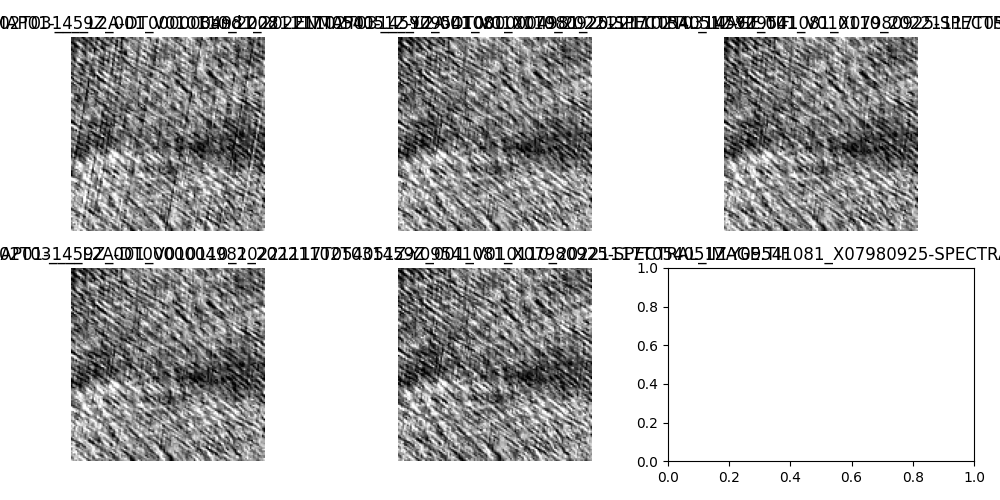

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_021/tile_021-patch_09/ENMAP01-____L2A-DT0000004990_20221104T023107Z_009_V010110_20221118T181236Z-Y03010428_X04360563-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Preview saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_021/tile_021-patch_09/ENMAP01-____L2A-DT0000004990_20221104T023107Z_009_V010110_20221118T181236Z-Y03010428_X04360563-SPECTRAL_IMAGE_preview.png


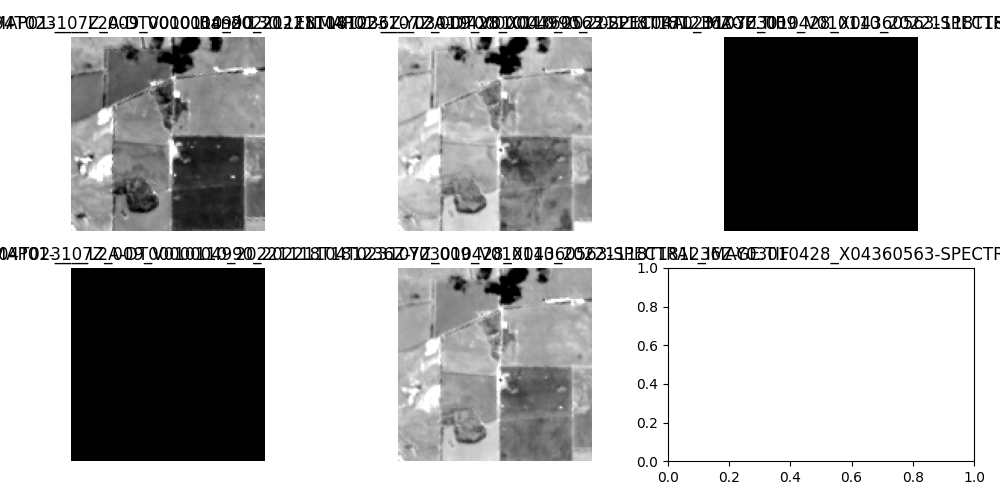

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_013/tile_013-patch_10/ENMAP01-____L2A-DT0000004990_20221104T023031Z_001_V010110_20221116T194948Z-Y02730400_X07960923-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Preview saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_013/tile_013-patch_10/ENMAP01-____L2A-DT0000004990_20221104T023031Z_001_V010110_20221116T194948Z-Y02730400_X07960923-SPECTRAL_IMAGE_preview.png


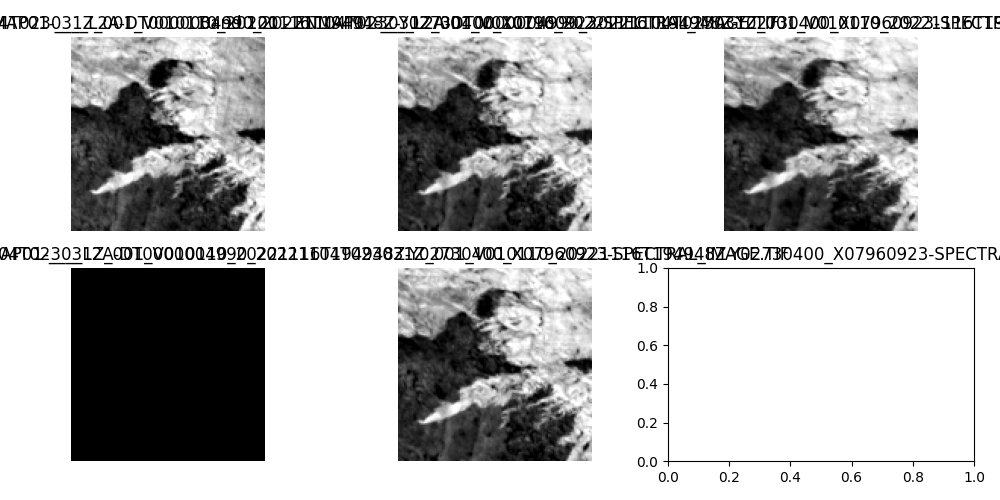

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_002/tile_002-patch_34/ENMAP01-____L2A-DT0000004990_20221104T023116Z_011_V010110_20221119T005504Z-Y06870814_X05630690-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Preview saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_002/tile_002-patch_34/ENMAP01-____L2A-DT0000004990_20221104T023116Z_011_V010110_20221119T005504Z-Y06870814_X05630690-SPECTRAL_IMAGE_preview.png


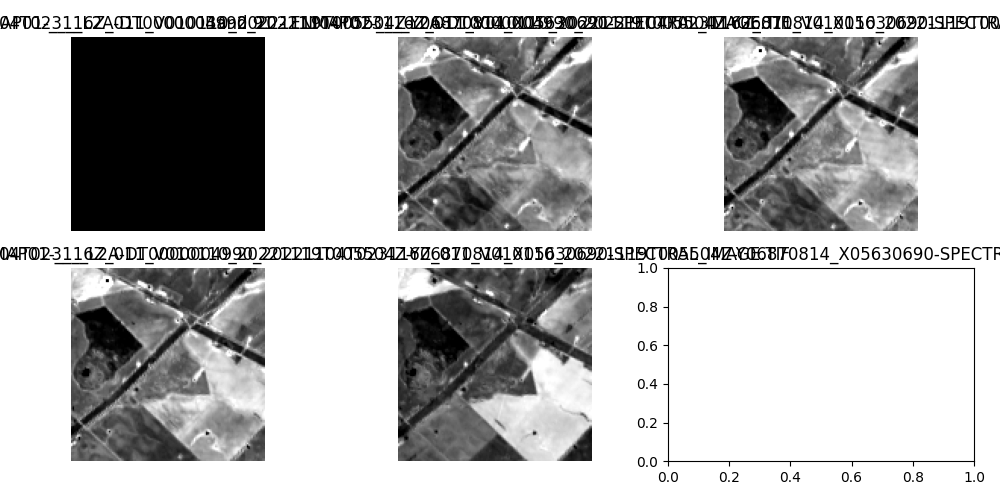

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_023/tile_023-patch_25/ENMAP01-____L2A-DT0000004981_20221102T031459Z_001_V010110_20221117T054051Z-Y05700697_X04140541-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Preview saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_023/tile_023-patch_25/ENMAP01-____L2A-DT0000004981_20221102T031459Z_001_V010110_20221117T054051Z-Y05700697_X04140541-SPECTRAL_IMAGE_preview.png


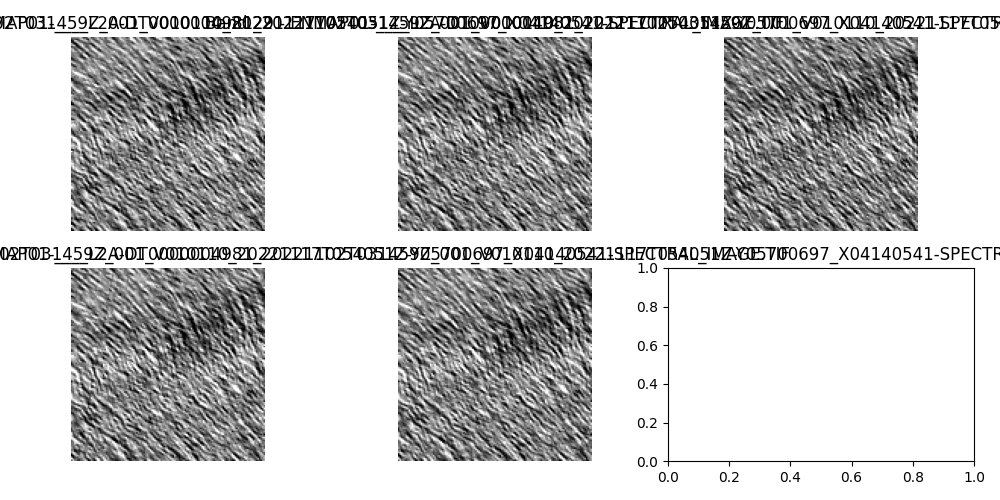

In [ ]:
# Function to call 
main()

## Create and Display a False-Color (RGB) to visualise the data (optional)

In [ ]:
#| export
from IPython.display import Image, display

def display_false_color_composite(tif_files, num_samples=5):
    """
    Displays a false-color composite for selected .tif files.

    Args:
        tif_files (list): List of .tif file paths.
        num_samples (int): Number of random samples to process.
    """
    if len(tif_files) < num_samples:
        print("Not enough .tif files found. Displaying all available files.")
        selected_files = tif_files
    else:
        selected_files = random.sample(tif_files, num_samples)

    for file_path in selected_files:
        print(f"Processing file: {file_path}")

        try:
            with rasterio.open(file_path) as src:
                img = src.read()
                no_data_value = src.nodata

                # Replace no-data values with NaN
                if no_data_value is not None:
                    img = np.where(img == no_data_value, np.nan, img)

                num_bands = img.shape[0]
                print(f"Number of bands in image: {num_bands}")

                # Check if there are enough bands for a false-color composite
                if num_bands < 50:
                    print(f"Not enough bands for false-color composite. Skipping file: {file_path}")
                    continue

                # Select bands for false-color composite
                red_band = img[49]  # Near-infrared (Band 50)
                green_band = img[29]  # Red (Band 30)
                blue_band = img[9]   # Green (Band 10)

                # Normalize the bands
                red = normalize_band(red_band)
                green = normalize_band(green_band)
                blue = normalize_band(blue_band)

                # Create an RGB composite
                rgb_image = np.dstack((red, green, blue))

                # Save the false-color composite as an image file
                output_path = f"{os.path.splitext(file_path)[0]}_false_color.png"
                plt.figure(figsize=(5, 5))
                plt.imshow(rgb_image)
                plt.title(f"False-Color Composite - {os.path.basename(file_path)}")
                plt.axis('off')
                plt.savefig(output_path)
                plt.close()
                print(f"Image saved as: {output_path}")

                # Display the saved image in the notebook
                display(Image(output_path))

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

import numpy as np
#|export
def normalize_band(band):
    """
    Normalize the spectral band data to the range [0, 1].
    
    Args:
        band (numpy.ndarray): Array representing one band of the spectral image.

    Returns:
        numpy.ndarray: Normalized band data.
    """
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)
    return (band - band_min) / (band_max - band_min)


def main_false_color():
    """
    Main function to collect, process, and display false-color composites.
    """
    tif_files = collect_tif_files()
    display_false_color_composite(tif_files)


Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_013/tile_013-patch_34/ENMAP01-____L2A-DT0000004990_20221104T023031Z_001_V010110_20221116T194948Z-Y06570784_X07960923-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Image saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_013/tile_013-patch_34/ENMAP01-____L2A-DT0000004990_20221104T023031Z_001_V010110_20221116T194948Z-Y06570784_X07960923-SPECTRAL_IMAGE_false_color.png


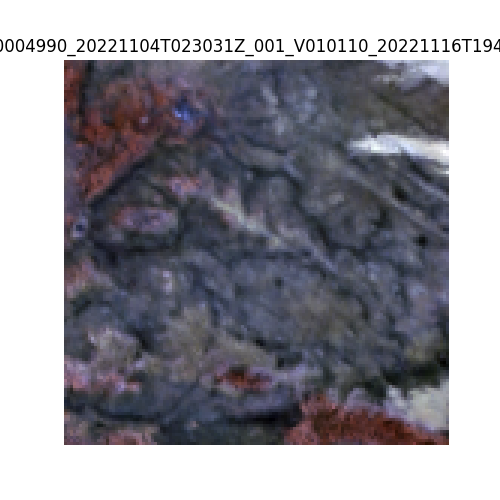

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_005/tile_005-patch_47/ENMAP01-____L2A-DT0000004981_20221102T031517Z_005_V010110_20221117T035000Z-Y09111038_X08150942-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Image saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_005/tile_005-patch_47/ENMAP01-____L2A-DT0000004981_20221102T031517Z_005_V010110_20221117T035000Z-Y09111038_X08150942-SPECTRAL_IMAGE_false_color.png


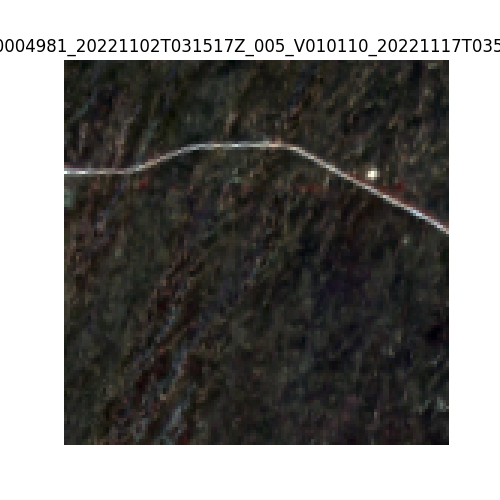

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_016/tile_016-patch_27/ENMAP01-____L2A-DT0000004990_20221104T023045Z_004_V010110_20221118T202506Z-Y05340661_X07970924-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Image saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_016/tile_016-patch_27/ENMAP01-____L2A-DT0000004990_20221104T023045Z_004_V010110_20221118T202506Z-Y05340661_X07970924-SPECTRAL_IMAGE_false_color.png


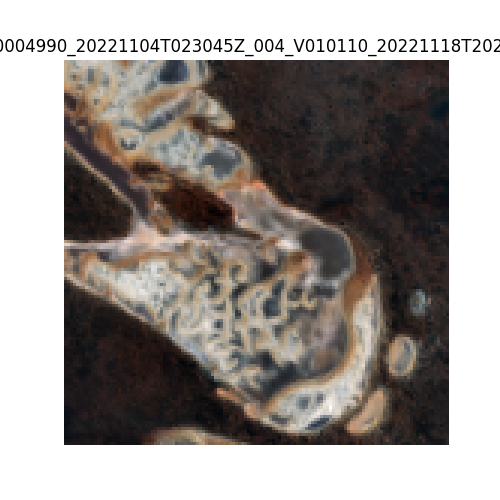

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_023/tile_023-patch_36/ENMAP01-____L2A-DT0000004981_20221102T031459Z_001_V010110_20221117T054051Z-Y06980825_X09261053-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Image saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_023/tile_023-patch_36/ENMAP01-____L2A-DT0000004981_20221102T031459Z_001_V010110_20221117T054051Z-Y06980825_X09261053-SPECTRAL_IMAGE_false_color.png


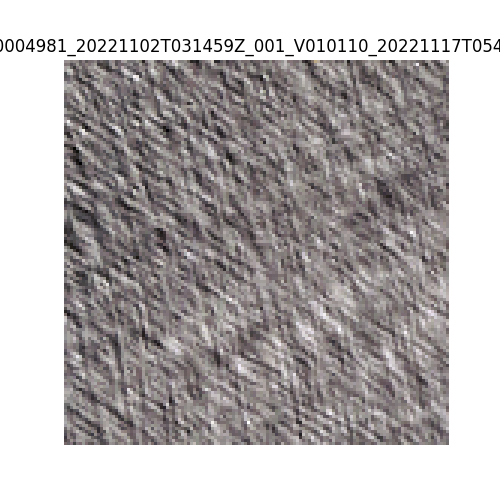

Processing file: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_025/tile_025-patch_47/ENMAP01-____L2A-DT0000004981_20221102T031508Z_003_V010110_20221116T141823Z-Y09111038_X08150942-SPECTRAL_IMAGE.TIF
Number of bands in image: 224
Image saved as: /root/hsi-compression/datasets/hyspecnet-11k/patches/tile_025/tile_025-patch_47/ENMAP01-____L2A-DT0000004981_20221102T031508Z_003_V010110_20221116T141823Z-Y09111038_X08150942-SPECTRAL_IMAGE_false_color.png


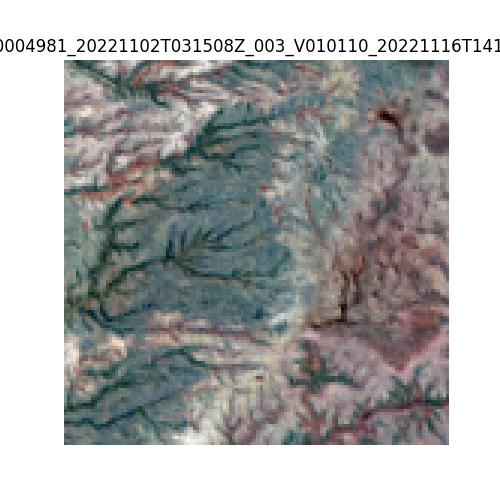

In [ ]:
# Function to false-color composite 
main_false_color()

## Converting SPECTRAL_IMAGE.TIF to DATA.npy for testing

The *-DATA.npy files have to be generated by running the tif_to_npy.py In the *-DATA.npy files the number of bands is reduced from 224 to 202 by removing bands [127 – 141] and [161 – 167] that are affected by strong water vapor absorption. The data is clipped and rescaled to the range [0 – 1] using min-max normalization. Furthermore, the data is converted to float32.

## Test Run

In [ ]:
#| eval: False

os.chdir("/root/hsi-compression")
!bash test.sh

Loading ./results/weights/cae1d_8bpppc.pth.tar
/root/hsi-compression/utils/checkpoint.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_

## Analysing the test case

In [ ]:
#| export
import json
import os

def analyze_results(json_file="/root/hsi-compression/results/tests/weights.json"):
    """
    Analyzes the compression results from a given JSON file and prints key metrics.

    Args:
        json_file (str): Path to the JSON file containing the compression results.
    """
    if not os.path.exists(json_file):
        print(f"File not found: {json_file}")
        return

    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract values
    name = data.get("name", "N/A")
    description = data.get("description", "No description")
    bpppc = data["results"].get("bpppc", [None])[0]
    psnr = data["results"].get("psnr", [None])[0]
    ssim = data["results"].get("ssim", [None])[0]
    sa = data["results"].get("sa", [None])[0]
    encoding_time = data["results"].get("encoding_time", [None])[0]
    decoding_time = data["results"].get("decoding_time", [None])[0]

    # Print extracted values
    print(f"Name: {name}")
    print(f"Description: {description}")
    print(f"Bits Per Pixel Per Channel (bpppc): {bpppc:.2f}")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")
    if sa is not None:
        print(f"Spectral Angle (SA): {sa:.2f}")
    else:
        print("Spectral Angle (SA): Not available")

    print(f"Encoding Time: {encoding_time:.4f} seconds")
    print(f"Decoding Time: {decoding_time:.4f} seconds")

    # Inference Analysis
    if psnr > 40 and ssim > 0.95:
        print("Inference: The compression maintains high image quality.")
    else:
        print("Inference: The compression may have degraded image quality.")

    if encoding_time < 0.01:
        print("Inference: The encoding process is fast.")
    else:
        print("Inference: The encoding process is relatively slow.")

    if decoding_time < 0.01:
        print("Inference: The decoding process is fast.")
    else:
        print("Inference: The decoding process is relatively slow.")



In [ ]:
analyze_results()

Name: cae1d
Description: Test
Bits Per Pixel Per Channel (bpppc): 8.08
PSNR: 56.37 dB
SSIM: 0.9993
Spectral Angle (SA): Not available
Encoding Time: 0.0024 seconds
Decoding Time: 0.0109 seconds
Inference: The compression maintains high image quality.
Inference: The encoding process is fast.
Inference: The decoding process is relatively slow.


In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()